# Movielens dataset

## Data Exploration and Movie Recommendation using Collaborative Filtering and Stochastic Gradient Descent

### How movies evolve over time?

In [164]:
import pandas as pd
import numpy as np

In [165]:
movies = pd.read_csv('./movielens-20m-dataset/movie.csv')
#rating = pd.read_csv('./movielens-20m-dataset/rating.csv')
#tag = pd.read_csv('./movielens-20m-dataset/tag.csv')

In [166]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Extract Title and Year

The 'title' columns consists of movie title following by year of release in the blanket, we will use regular expression to extract year information from this field

In [167]:
import re
movies['title_format'] = movies['title'].apply(lambda x: re.search('\(\d+\)',x))

In [168]:
movies.head()

,movieId,title,genres,title_format
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,<_sre.SRE_Match object at 0x10d2c5e68>
1,2,Jumanji (1995),Adventure|Children|Fantasy,<_sre.SRE_Match object at 0x10d2c5ed0>
2,3,Grumpier Old Men (1995),Comedy|Romance,<_sre.SRE_Match object at 0x10d2c5f38>
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,<_sre.SRE_Match object at 0x10c3ee030>
4,5,Father of the Bride Part II (1995),Comedy,<_sre.SRE_Match object at 0x10c3ee098>


However, regular expression does not find this format in some rows

In [169]:
movies[movies['title_format'].isnull()]

,movieId,title,genres,title_format
10593,40697,Babylon 5,Sci-Fi,None
15646,79607,"Millions Game, The (Das Millionenspiel)",Action|Drama|Sci-Fi|Thriller,None
17341,87442,"Bicycle, Spoon, Apple (Bicicleta, cullera, poma)",Documentary,None
22368,107434,Diplomatic Immunity (2009– ),Comedy,None
22669,108548,"Big Bang Theory, The (2007-)",Comedy,None
22679,108583,Fawlty Towers (1975-1979),Comedy,None
23617,112406,Brazil: In the Shadow of the Stadiums,Documentary,None
23824,113190,Slaying the Badger,Documentary,None
24286,115133,Tatort: Im Schmerz geboren,Crime,None
24412,115685,National Theatre Live: Frankenstein,Drama|Fantasy,None


Remove from list movies with no release year

In [170]:
# Remove from list movies with no release year
movies = movies[movies['title_format'].isnull()==False]

In [171]:
movies.shape

(27256, 4)

Using regular expression, extract movies' title names and released year

In [172]:
movies['title_name'] = movies['title'].apply(lambda x: x[:re.search('\(\d+\)',x).start()])
movies['year'] = movies['title'].apply(lambda x: re.search('\(\d+\)',x).group(0))
movies['released_year'] = movies['year'].apply(lambda x: re.search('\d+',x).group())

In [173]:
movies.head()

,movieId,title,genres,title_format,title_name,year,released_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,<_sre.SRE_Match object at 0x10d2c5e68>,Toy Story,(1995),1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,<_sre.SRE_Match object at 0x10d2c5ed0>,Jumanji,(1995),1995
2,3,Grumpier Old Men (1995),Comedy|Romance,<_sre.SRE_Match object at 0x10d2c5f38>,Grumpier Old Men,(1995),1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,<_sre.SRE_Match object at 0x10c3ee030>,Waiting to Exhale,(1995),1995
4,5,Father of the Bride Part II (1995),Comedy,<_sre.SRE_Match object at 0x10c3ee098>,Father of the Bride Part II,(1995),1995


### Explore movies by the year of release

In [174]:
movies_by_year = movies['released_year'].value_counts().reset_index()
movies_by_year.columns = ['released_year','number_of_movies']
movies_by_year = movies_by_year.sort_values(by='released_year')

In [175]:
movies_by_year.head()

,released_year,number_of_movies
112,06,1
111,1891,1
120,1893,1
107,1894,2
108,1895,2


Remove year with uncommon value (i.e. 06, 500, 69) from the dataframe

In [176]:
movies.shape, movies_by_year.shape

((27256, 7), (121, 2))

In [177]:
movies = movies[movies.released_year.isin(['06','500','69'])==False]
movies_by_year = movies_by_year[movies_by_year.isin(['06','500','69'])==False]

In [178]:
movies.shape, movies_by_year.shape

((27253, 7), (121, 2))

Plot number of movies by released year

In [179]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]),
 <a list of 118 Text xticklabel objects>)

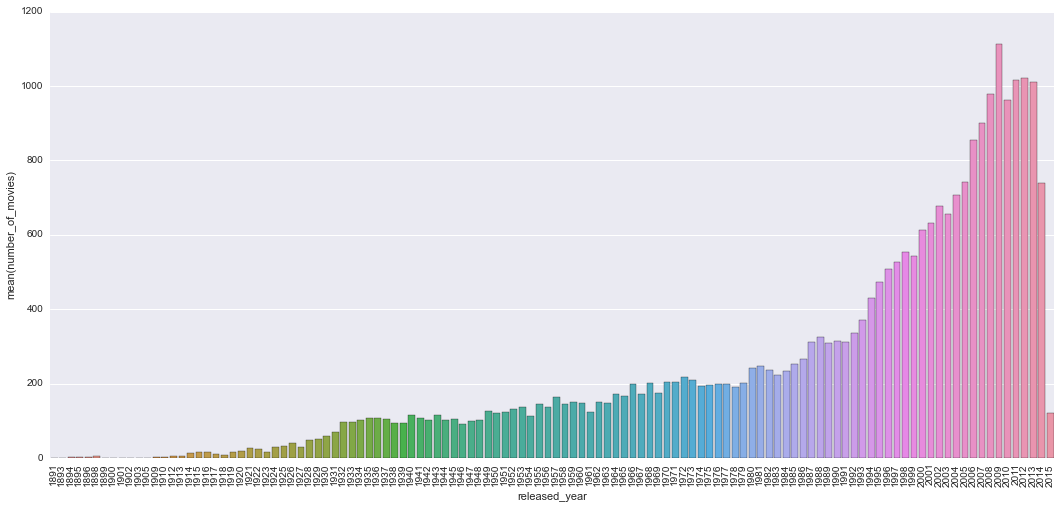

In [180]:
plt.rcParams['figure.figsize'] = (18, 8)
ax = sns.barplot(movies_by_year.released_year, movies_by_year.number_of_movies)
plt.xticks(rotation=90)

We can see that the number of movies grew more significantly from 1990

### Extract Genre
Genre list are stored in Genre field by list separated by '|'
Using pandas get_dummies function to split this list into dummy code

In [181]:
movies_genre = movies.genres.str.get_dummies('|')

In [182]:
movies_genre.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Merge Genre list into original dataframe

In [183]:
df_movies = pd.merge(movies, movies_genre, how='inner', left_index=True, right_index=True)

In [184]:
df_movies.head()

,movieId,title,genres,title_format,title_name,year,released_year,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,<_sre.SRE_Match object at 0x10d2c5e68>,Toy Story,(1995),1995,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,<_sre.SRE_Match object at 0x10d2c5ed0>,Jumanji,(1995),1995,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,<_sre.SRE_Match object at 0x10d2c5f38>,Grumpier Old Men,(1995),1995,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,<_sre.SRE_Match object at 0x10c3ee030>,Waiting to Exhale,(1995),1995,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,<_sre.SRE_Match object at 0x10c3ee098>,Father of the Bride Part II,(1995),1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's see how many movies do not have any genre

In [185]:
df_movies[df_movies['(no genres listed)']==1]

,movieId,title,genres,title_format,title_name,year,released_year,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
16574,83773,Away with Words (San tiao ren) (1999),(no genres listed),<_sre.SRE_Match object at 0x10e5c3098>,Away with Words (San tiao ren),(1999),1999,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16589,83829,Scorpio Rising (1964),(no genres listed),<_sre.SRE_Match object at 0x10e5c36b0>,Scorpio Rising,(1964),1964,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16764,84768,Glitterbug (1994),(no genres listed),<_sre.SRE_Match object at 0x10e5c8098>,Glitterbug,(1994),1994,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17080,86493,"Age of the Earth, The (A Idade da Terra) (1980)",(no genres listed),<_sre.SRE_Match object at 0x10e5d0578>,"Age of the Earth, The (A Idade da Terra)",(1980),1980,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17243,87061,Trails (Veredas) (1978),(no genres listed),<_sre.SRE_Match object at 0x10e5d49f0>,Trails (Veredas),(1978),1978,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18246,91246,Milky Way (Tejút) (2007),(no genres listed),<_sre.SRE_Match object at 0x10e5ef030>,Milky Way (Tejút),(2007),2007,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18566,92435,"Dancing Hawk, The (Tanczacy jastrzab) (1978)",(no genres listed),<_sre.SRE_Match object at 0x10e5f76b0>,"Dancing Hawk, The (Tanczacy jastrzab)",(1978),1978,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18606,92641,Warsaw Bridge (Pont de Varsòvia) (1990),(no genres listed),<_sre.SRE_Match object at 0x10ef60780>,Warsaw Bridge (Pont de Varsòvia),(1990),1990,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18984,94431,"Ella Lola, a la Trilby (1898)",(no genres listed),<_sre.SRE_Match object at 0x10ef6a6b0>,"Ella Lola, a la Trilby",(1898),1898,1,0,0,...,0,0,0,0,0,0,0,0,0,0
19015,94657,"Turkish Dance, Ella Lola (1898)",(no genres listed),<_sre.SRE_Match object at 0x10ef6b3d8>,"Turkish Dance, Ella Lola",(1898),1898,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Plot number of movies by genre over time
Let's look at some selected genres

In [186]:
genre_list = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
              'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
              'Musical','Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
year_genre_movies = df_movies.groupby(['released_year'])[genre_list].sum()

In [187]:
year_genre_movies.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
released_year,,,,,,,,,,,,,,,,,,,
1891,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1893,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1894,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1895,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1896,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


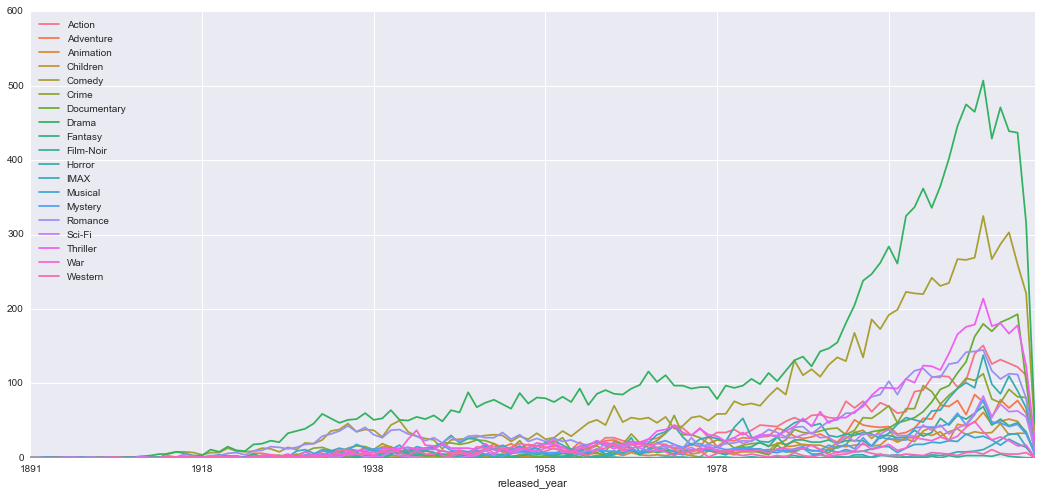

In [188]:
#sns.palplot(sns.color_palette("hls", 8))
sns.set_palette(sns.color_palette("husl",len(genre_list)))
ax = year_genre_movies.plot()

In [189]:
for genre in genre_list:
    print genre + ': ' + str(year_genre_movies[genre].sum())

Action: 3519
Adventure: 2329
Animation: 1027
Children: 1139
Comedy: 8368
Crime: 2938
Documentary: 2467
Drama: 13337
Fantasy: 1411
Film-Noir: 330
Horror: 2611
IMAX: 196
Musical: 1035
Mystery: 1513
Romance: 4125
Sci-Fi: 1741
Thriller: 4177
War: 1194
Western: 676


The plot shows too many lines, which is quite confusing. Let's look at only major genres

In [191]:
genre_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
              'Drama', 'Fantasy', 'Horror', 
              'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
year_genre_movies = df_movies.groupby(['released_year'])[genre_list].sum()

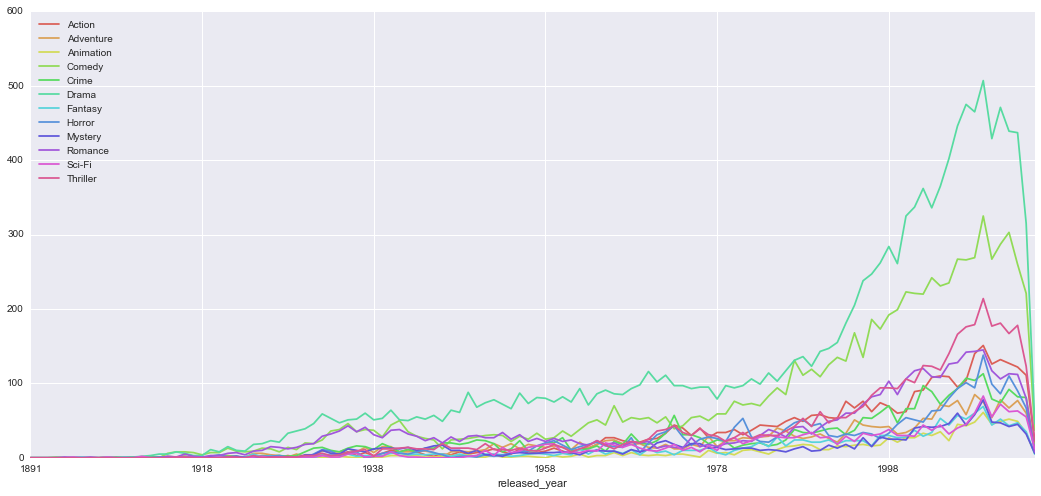

In [192]:
sns.set_palette(sns.color_palette("hls",len(genre_list)))
ax = year_genre_movies.plot()

In [29]:
year_genre_movies['Action'].sum()

3519

### Which genres receive the highest ratings? 

#### Load Rating dataset

In [193]:
rating = pd.read_csv('./movielens-20m-dataset/rating.csv')

In [194]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [195]:
rating.shape

(20000263, 4)

In [196]:
df_movies.head()

,movieId,title,genres,title_format,title_name,year,released_year,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,<_sre.SRE_Match object at 0x10d2c5e68>,Toy Story,(1995),1995,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,<_sre.SRE_Match object at 0x10d2c5ed0>,Jumanji,(1995),1995,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,<_sre.SRE_Match object at 0x10d2c5f38>,Grumpier Old Men,(1995),1995,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,<_sre.SRE_Match object at 0x10c3ee030>,Waiting to Exhale,(1995),1995,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,<_sre.SRE_Match object at 0x10c3ee098>,Father of the Bride Part II,(1995),1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Average movie rating

In [197]:
average_rating = rating.groupby('movieId')['rating'].mean()

In [198]:
average_rating.head()

movieId
1    3.921240
2    3.211977
3    3.151040
4    2.861393
5    3.064592
Name: rating, dtype: float64

In [199]:
average_rating.shape

(26744,)

In [200]:
average_rating = average_rating.reset_index()

In [201]:
average_rating.head()

,movieId,rating
0,1,3.921240
1,2,3.211977
2,3,3.151040
3,4,2.861393
4,5,3.064592


In [202]:
df_movies.shape

(27253, 27)

In [203]:
df_movies_rating = pd.merge(df_movies, average_rating, how='left', on='movieId')

In [204]:
df_movies_rating.shape

(27253, 28)

In [205]:
df_movies_rating.head()

,movieId,title,genres,title_format,title_name,year,released_year,(no genres listed),Action,Adventure,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,<_sre.SRE_Match object at 0x10d2c5e68>,Toy Story,(1995),1995,0,0,1,...,0,0,0,0,0,0,0,0,0,3.921240
1,2,Jumanji (1995),Adventure|Children|Fantasy,<_sre.SRE_Match object at 0x10d2c5ed0>,Jumanji,(1995),1995,0,0,1,...,0,0,0,0,0,0,0,0,0,3.211977
2,3,Grumpier Old Men (1995),Comedy|Romance,<_sre.SRE_Match object at 0x10d2c5f38>,Grumpier Old Men,(1995),1995,0,0,0,...,0,0,0,0,1,0,0,0,0,3.151040
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,<_sre.SRE_Match object at 0x10c3ee030>,Waiting to Exhale,(1995),1995,0,0,0,...,0,0,0,0,1,0,0,0,0,2.861393
4,5,Father of the Bride Part II (1995),Comedy,<_sre.SRE_Match object at 0x10c3ee098>,Father of the Bride Part II,(1995),1995,0,0,0,...,0,0,0,0,0,0,0,0,0,3.064592


#### Average rating by genre

In [206]:
for genre in genre_list:
    print genre, 'rating: ', df_movies_rating[df_movies_rating[genre]==1].rating.mean(), 'number of movies: ', \
          len(df_movies_rating[df_movies_rating[genre]==1])

Action rating:  2.97683354086 number of movies:  3519
Adventure rating:  3.07240749419 number of movies:  2329
Animation rating:  3.17709521251 number of movies:  1027
Comedy rating:  3.07418201523 number of movies:  8368
Crime rating:  3.16685282624 number of movies:  2938
Drama rating:  3.2620628153 number of movies:  13337
Fantasy rating:  3.09308425427 number of movies:  1411
Horror rating:  2.69679576528 number of movies:  2611
Mystery rating:  3.13499663245 number of movies:  1513
Romance rating:  3.2055452952 number of movies:  4125
Sci-Fi rating:  2.88951055437 number of movies:  1741
Thriller rating:  3.01606878534 number of movies:  4177


## Collaborative Filtering Recommendation System

In this section, we build a recommendation system based on the movie rating data using the technique called 'Collaborative filtering' to predict the rating of the movies a user has not rated yet and to provide list of recommended movies based on those predicted rating.

In [207]:
rating.shape

(20000263, 4)

In [208]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


Before setting up the dataset for the collaborative filtering, we explore rating dataset in more details

### Number of reviews by user (distribution)
The chart below shows the distribution of the count of rating given by unique users. It illustrates that majority of users provided only few movie ratings.

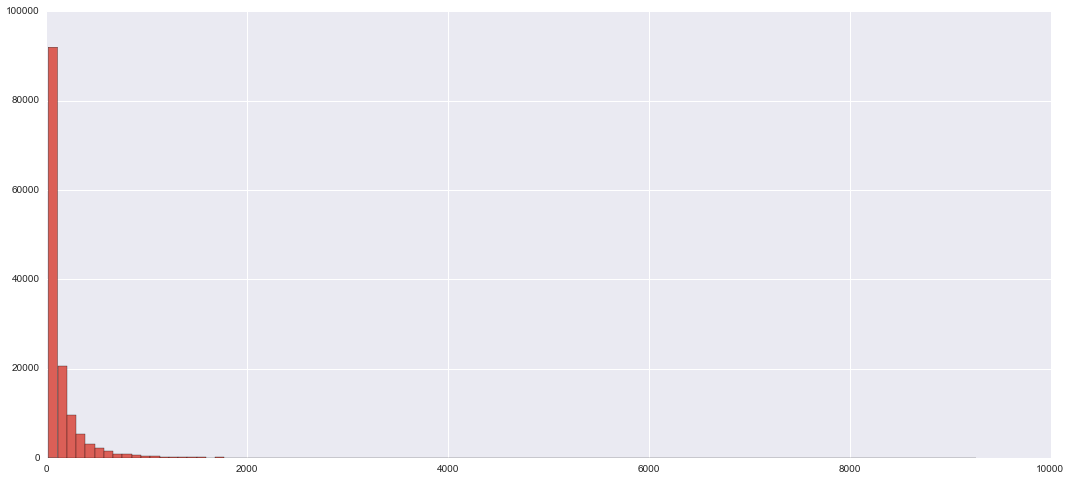

In [209]:
count_review_by_user = rating.groupby('userId')['rating'].count()
count_review_by_user.hist(bins=100)

### Number of reviews by movie (distribution)
The chart below shows the distribution of the count of ratings received by each movie. It also illustrated that majority of the movies received rating only from few users.

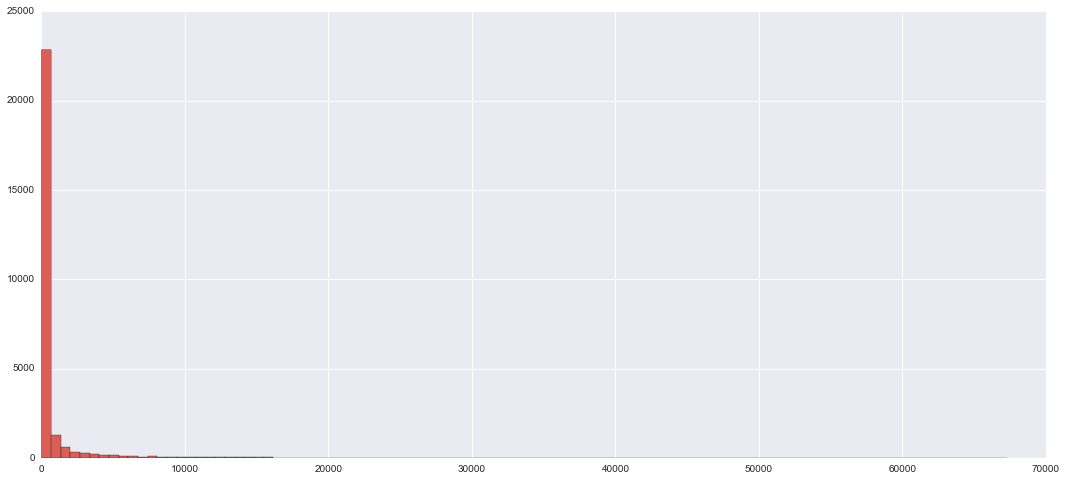

In [211]:
count_review_by_movie = rating.groupby('movieId')['rating'].count()
count_review_by_movie.hist(bins=100)

In [212]:
count_review_by_movie.describe()

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: rating, dtype: float64

In [213]:
count_review_by_movie[count_review_by_movie==67310]

movieId
296    67310
Name: rating, dtype: int64

#### Pulp Fiction has received rating by 67,310 users
After looking at the count of reviews by movie, we found that 'Pulp Fiction' has received the highest number of ratings count

In [214]:
movies[movies.movieId==296]

,movieId,title,genres,title_format,title_name,year,released_year
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,<_sre.SRE_Match object at 0x10c3f59f0>,Pulp Fiction,(1994),1994


### Average rating by user and by movie:
##### Average rating by user: for a user, what is the average movie rating this user gave?
##### Average rating by movie: for a movie, what is the average rating it has?

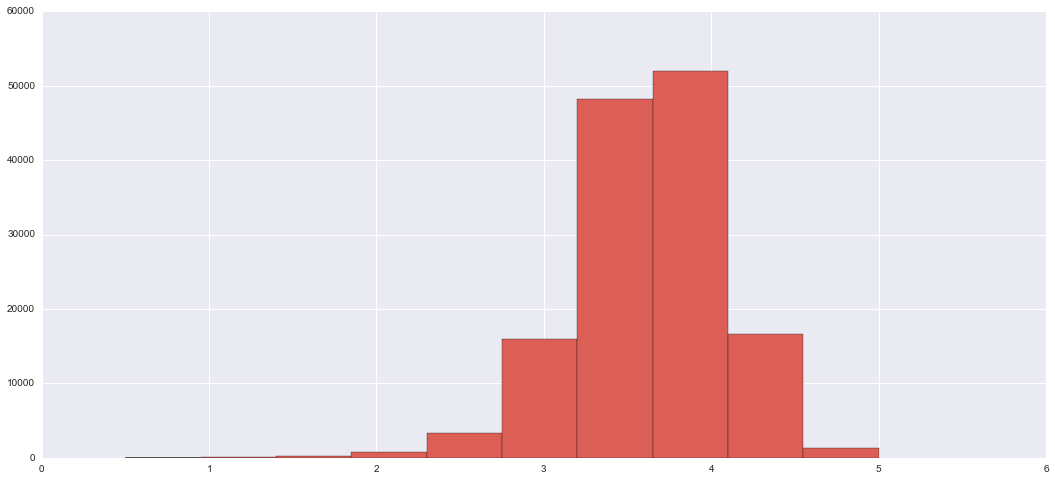

In [215]:
average_rating_by_user = rating.groupby('userId')['rating'].mean()
average_rating_by_user.hist()

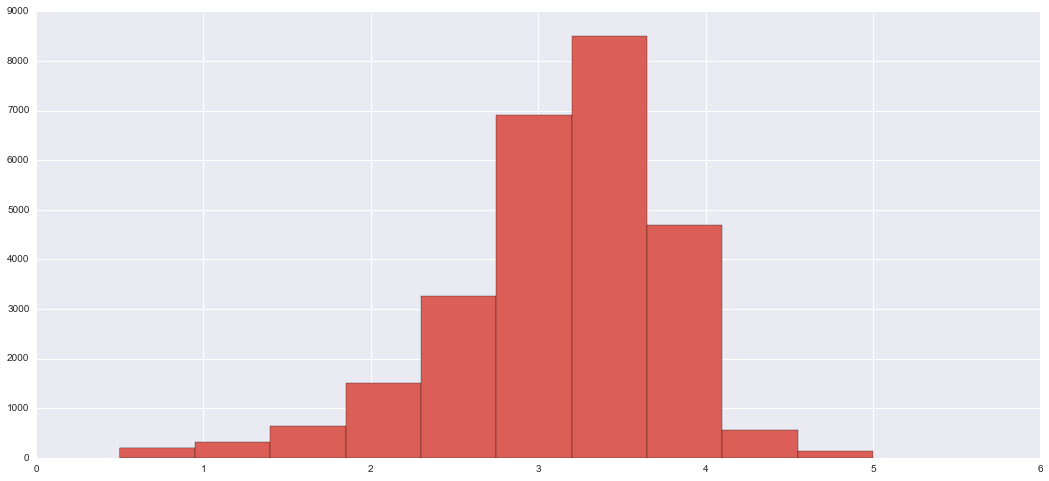

In [216]:
average_rating_by_movie = rating.groupby('movieId')['rating'].mean()
average_rating_by_movie.hist()

In [217]:
print "Average rating by user = ", average_rating_by_user.mean()
print "Average rating by movie = ", average_rating_by_movie.mean()

Average rating by user =  3.62720862189
Average rating by movie =  3.13319999013


### Prepare dataset for Collaborative filtering

In [218]:
# Merge Review count and Average review to original dataframe
count_review_by_user.shape, count_review_by_movie.shape, average_rating_by_user.shape, average_rating_by_movie.shape

((138493,), (26744,), (138493,), (26744,))

In [219]:
count_review_by_user = count_review_by_user.reset_index()
count_review_by_movie = count_review_by_movie.reset_index()

In [220]:
average_rating_by_user = average_rating_by_user.reset_index()
average_rating_by_movie = average_rating_by_movie.reset_index()

In [221]:
count_review_by_user.columns = ['userId','count_rating_user']
count_review_by_movie.columns = ['movieId','count_rating_movie']

In [222]:
average_rating_by_user.columns = ['userId','average_rating_user']
average_rating_by_movie.columns = ['movieId','average_rating_movie']

In [223]:
df_rating = pd.merge(rating, count_review_by_user, how='left', on='userId')

In [224]:
df_rating = pd.merge(df_rating, count_review_by_movie, how='left', on='movieId')

In [225]:
df_rating = pd.merge(df_rating, average_rating_by_user, how='left', on='userId')

In [226]:
df_rating = pd.merge(df_rating, average_rating_by_movie, how='left', on='movieId')

In [227]:
df_rating.head()

,userId,movieId,rating,timestamp,count_rating_user,count_rating_movie,average_rating_user,average_rating_movie
0,1,2,3.5,2005-04-02 23:53:47,175,22243,3.742857,3.211977
1,1,29,3.5,2005-04-02 23:31:16,175,8520,3.742857,3.952230
2,1,32,3.5,2005-04-02 23:33:39,175,44980,3.742857,3.898055
3,1,47,3.5,2005-04-02 23:32:07,175,43249,3.742857,4.053493
4,1,50,3.5,2005-04-02 23:29:40,175,47006,3.742857,4.334372


In [228]:
df_rating.count_rating_user.describe()

count    2.000026e+07
mean     5.115718e+02
std      6.633559e+02
min      2.000000e+01
25%      1.230000e+02
50%      2.960000e+02
75%      6.440000e+02
max      9.254000e+03
Name: count_rating_user, dtype: float64

In [229]:
df_rating.count_rating_movie.describe()

count    2.000026e+07
mean     1.348038e+04
std      1.411208e+04
min      1.000000e+00
25%      2.963000e+03
50%      8.505000e+03
75%      1.967400e+04
max      6.731000e+04
Name: count_rating_movie, dtype: float64

#### For demonstration purpose, we use smaller subset of rating data for this recommendation system
#### We select the ratings for movie with more than 5,000 reviews and user with more than 1,500 reviews

In [231]:
#### We will work with small subset of rating data, rating for movie with more than 60,000 reviews and user with more than 1,000 reviews
rating_subset = df_rating[(df_rating.count_rating_user >= 1500) & (df_rating.count_rating_movie >= 5000)]

In [232]:
rating_subset.shape, rating.shape

((389724, 8), (20000263, 4))

In essence, after subsetting the data, we now have the rating data of 1,005 movies from 581 unique users

In [234]:
len(rating_subset.userId.unique()), len(rating_subset.movieId.unique())

(581, 1005)

#### We organize the srating data into n x m matrix, where n is the number of users and m is the number of movies

In [235]:
# Initiate number of users and movies
n_users = rating_subset.userId.unique().shape[0]
n_movies = rating_subset.movieId.unique().shape[0]

In [236]:
print n_users, n_movies

581 1005


In [237]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(rating_subset, test_size=0.25)

In [238]:
train_data.shape, test_data.shape

((292293, 8), (97431, 8))

In [239]:
len(train_data.userId.unique()), len(test_data.userId.unique()), len(train_data.movieId.unique()), len(test_data.movieId.unique())

(581, 581, 1005, 1005)

In [240]:
train_data.head()

,userId,movieId,rating,timestamp,count_rating_user,count_rating_movie,average_rating_user,average_rating_movie
951082,6373,6281,2.5,2005-10-07 17:04:15,1929,5101,2.674702,3.355911
2322440,15718,2000,2.5,2004-02-23 16:57:42,1933,17620,3.448008,3.690636
18709309,129540,7143,3.5,2004-01-10 02:23:10,2050,10464,3.441951,3.694285
743726,4967,743,3.0,2012-04-18 07:14:20,1719,6112,3.280686,2.738138
3973538,27054,1235,3.0,2002-06-03 02:10:07,1786,8066,2.974244,3.999814


In [241]:
# Create training and test matrix using Pandas pivot
ptrain = train_data.pivot(index='userId', columns='movieId', values='rating')

In [242]:
ptrain.head()

movieId,1,2,3,5,6,7,10,11,14,16,...,70286,71535,72998,73017,74458,78499,79132,80463,81591,81845
userId,,,,,,,,,,,,,,,,,,,,,
156,5.0,5.0,NaN,3.0,4.0,NaN,4.0,5.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,5.0,NaN,3.0,NaN,3.5,4.5,NaN,NaN,4.5,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
768,NaN,NaN,NaN,2.0,NaN,NaN,4.0,NaN,NaN,3.0,...,3.0,4.0,3.0,NaN,3.0,NaN,4.0,NaN,4.0,NaN
775,4.5,2.0,NaN,1.0,3.5,NaN,4.5,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,4.0,4.0,2.0,NaN,4.0,3.0,1.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
ptrain.shape, ptest.shape

((581, 1005), (581, 1005))

In [244]:
# Store Index of userId
train_user_index = pd.DataFrame(ptrain.index)

In [245]:
# Store Index of movieId
train_movies_index = pd.DataFrame(ptrain.columns)

In [246]:
ptest = test_data.pivot(index='userId', columns='movieId', values='rating')

In [247]:
ptest.head()

movieId,1,2,3,5,6,7,10,11,14,16,...,70286,71535,72998,73017,74458,78499,79132,80463,81591,81845
userId,,,,,,,,,,,,,,,,,,,,,
156,NaN,NaN,2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,NaN,3.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
768,NaN,3.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN
775,NaN,NaN,3.5,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
# fillna = 0
# Copy to new dataframe representing matrices
R = ptrain.fillna(0.0).copy().values
T = ptest.fillna(0.0).copy().values

In [249]:
R

array([[ 5. ,  5. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 5. ,  0. ,  3. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  4. ,  0. ],
       ..., 
       [ 0. ,  0. ,  4. , ...,  0. ,  0. ,  0. ],
       [ 3. ,  2. ,  2. , ...,  4.5,  3.5,  0. ],
       [ 5. ,  3. ,  0. , ...,  4.5,  4.5,  5. ]])

In [250]:
T

array([[ 0.,  0.,  2., ...,  0.,  0.,  0.],
       [ 0.,  3.,  0., ...,  0.,  0.,  0.],
       [ 0.,  3.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  3.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  3.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [251]:
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [79]:
# Predict the unknown ratings through the dot product of the latent features for users and items 
def prediction(P,Q):
    return np.dot(P.T,Q)

In [80]:
lmbda = 0.1 # Regularization weight
k = 20  # Dimensionality of the latent feature space
m, n = R.shape  # Number of users and items
n_epochs = 100  # Number of epochs
gamma=0.01  # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [81]:
# Calculate the RMSE
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - prediction(P,Q)))**2)/len(R[R > 0]))

In [82]:
R.nonzero()

(array([  0,   0,   0, ..., 580, 580, 580]),
 array([   0,    2,    3, ..., 1000, 1003, 1004]))

In [83]:
R.shape

(581, 1005)

In [86]:
Q.shape, P.shape

((20, 1005), (20, 581))

In [84]:
train_errors = []
test_errors = []

#Only consider non-zero matrix 
users,items = R.nonzero()      
for epoch in xrange(n_epochs):
    for u, i in zip(users,items):
        e = R[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient
        P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent movie feature matrix
    train_rmse = rmse(I,R,Q,P) # Calculate root mean squared error from train dataset
    test_rmse = rmse(I2,T,Q,P) # Calculate root mean squared error from test dataset
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

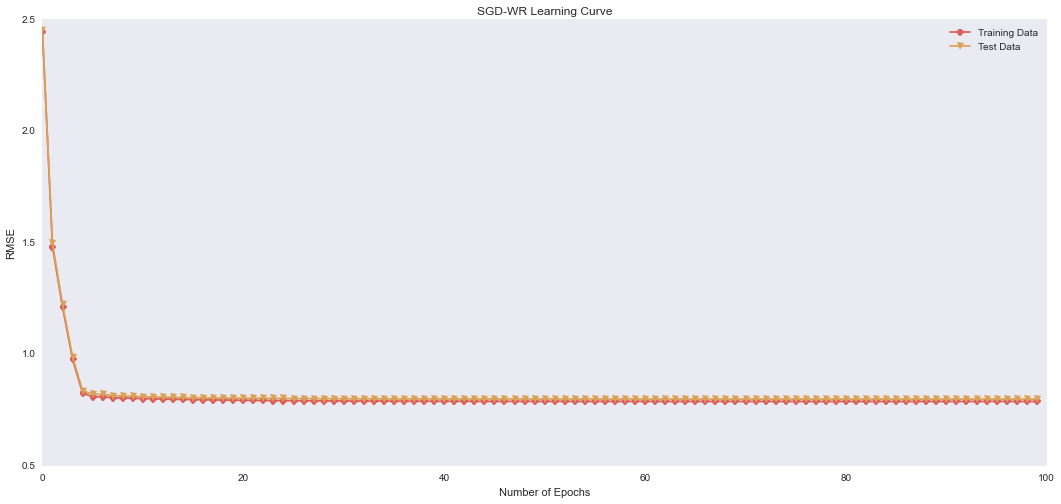

In [85]:
plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('SGD-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show() 

In [87]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R = pd.DataFrame(R)
R_hat=pd.DataFrame(prediction(P,Q))

In [89]:
# Compare true ratings of user 17 with predictions
ratings = pd.DataFrame(data=R.loc[16,R.loc[16,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[16,R.loc[16,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']
ratings

,Actual Rating,Predicted Rating
0,4.0,3.740324
4,4.0,3.504268
5,2.0,2.326177
6,4.0,2.866836
7,3.5,2.836804


In [90]:
P.shape, Q.shape

((20, 581), (20, 1005))

In [94]:
R.loc[16,:].head()

0    4.0
1    0.0
2    0.0
3    0.0
4    4.0
Name: 16, dtype: float64

In [95]:
R_hat.loc[16,:].head()

0    3.740324
1    2.532082
2    2.490984
3    2.122813
4    3.504268
Name: 16, dtype: float64

In [102]:
# Calculate prediction matrix T_hat (low-rank approximation for T)
T = pd.DataFrame(T)
T_hat=pd.DataFrame(prediction(P,Q))

In [103]:
T.loc[16,:].head()

0    0.0
1    2.5
2    0.0
3    0.0
4    0.0
Name: 16, dtype: float64

In [104]:
T_hat.loc[16,:].head()

0    3.740324
1    2.532082
2    2.490984
3    2.122813
4    3.504268
Name: 16, dtype: float64

In [118]:
train_user_index.loc[16,:].values[0]

3907

In [121]:
train_data[train_data.userId==train_user_index.loc[16,:].values[0]].count()

userId                544
movieId               544
rating                544
timestamp             544
count_rating_user     544
count_rating_movie    544
dtype: int64

In [125]:
# Rank rating prediction for user 17
predicted_ratings = pd.DataFrame(data=R_hat.loc[16,R.loc[16,:] == 0])

In [126]:
predicted_ratings.shape

(461, 1)

In [134]:
top_10_reco = predicted_ratings.sort_values(by=16,ascending=False).head(10)

In [135]:
top_10_reco

,16
242,4.074752
838,4.025135
317,4.012635
86,3.984353
189,3.963011
253,3.931674
799,3.931442
327,3.905271
349,3.899046
254,3.892770


In [137]:
top_10_reco.index.tolist()

[242, 838, 317, 86, 189, 253, 799, 327, 349, 254]

In [139]:
movies[movies.movieId.isin(top_10_reco.index.tolist())]

,movieId,title,genres,title_format,title_name,year,released_year
85,86,White Squall (1996),Action|Adventure|Drama,<_sre.SRE_Match object at 0x107390d98>,White Squall,(1996),1996
187,189,Reckless (1995),Comedy|Fantasy,<_sre.SRE_Match object at 0x1073938b8>,Reckless,(1995),1995
239,242,Farinelli: il castrato (1994),Drama|Musical,<_sre.SRE_Match object at 0x107394e68>,Farinelli: il castrato,(1994),1994
250,253,Interview with the Vampire: The Vampire Chroni...,Drama|Horror,<_sre.SRE_Match object at 0x107395370>,Interview with the Vampire: The Vampire Chroni...,(1994),1994
251,254,Jefferson in Paris (1995),Drama,<_sre.SRE_Match object at 0x1073953d8>,Jefferson in Paris,(1995),1995
314,317,"Santa Clause, The (1994)",Comedy|Drama|Fantasy,<_sre.SRE_Match object at 0x107396e00>,"Santa Clause, The",(1994),1994
323,327,Tank Girl (1995),Action|Comedy|Sci-Fi,<_sre.SRE_Match object at 0x107397238>,Tank Girl,(1995),1995
345,349,Clear and Present Danger (1994),Action|Crime|Drama|Thriller,<_sre.SRE_Match object at 0x107397b28>,Clear and Present Danger,(1994),1994
786,799,"Frighteners, The (1996)",Comedy|Horror|Thriller,<_sre.SRE_Match object at 0x1073a3510>,"Frighteners, The",(1996),1996
823,838,Emma (1996),Comedy|Drama|Romance,<_sre.SRE_Match object at 0x1073a44a8>,Emma,(1996),1996


In [163]:
average_rating_by_movie[average_rating_by_movie.movieId.isin(top_10_reco.index.tolist())]

,movieId,average_rating_movie
85,86,3.483403
187,189,3.001488
239,242,3.386617
250,253,3.496645
251,254,2.893482
314,317,3.146079
323,327,2.806328
345,349,3.660309
786,799,3.372460
823,838,3.796107
